# Get Statistics of Final Images

In [1]:
import os
import numpy as np
from astropy.io import fits

import matplotlib.pyplot as plt

## Load Image

In [59]:
cell = 0.3 # arcsec
obsname = "QSO-J1030+0524"
imdir = "/rds/user/pmk46/hpc-work/19A-056/final"
imfits = os.path.join(imdir, "images", f"{obsname}-res.im-MFS-image.fits")
imfitsV = os.path.join(imdir, "stokes-V", f"{obsname}-res-Stokes-V.im-MFS-image.fits")
image_data = fits.open(imfits)[0].data[0, 0]
image_data_V = fits.open(imfitsV)[0].data[0, 0]
header = fits.open(imfits)[0].header
beam = header["BMIN"] * header["BMAJ"] / (header["CDELT2"] * 2.355)**2

peak_flux_px = np.unravel_index(np.argmax(image_data), image_data.shape)
peak_flux = image_data[peak_flux_px] * 1000 # mJy
centre_px = np.array(image_data.shape) // 2
peak_flux_dist = cell * np.sqrt(np.sum((peak_flux_px - centre_px)**2)) / 60 # arcmin

cutout_size = 2048

def get_cutout(data, cutout_size):
    """ 
    Get a cutout of the centre of a 2D data array.
    """

    N = data.shape[0]
    pc = N // 2

    nstart = max(pc - cutout_size // 2, 0)
    nend = min(pc + cutout_size // 2, N)
    return data[nstart:nend, nstart:nend]

image_data_small = get_cutout(image_data, 16)
image_data = get_cutout(image_data, cutout_size)
image_data_V = get_cutout(image_data_V, cutout_size)

## Fit 2D Gaussian to Image Data

In [60]:
import numpy as np
from astropy.modeling import models, fitting

# Generate some sample data
N = image_data_small.shape[0]

x = np.arange(-N//2, N//2)
y = np.arange(-N//2, N//2)
X, Y = np.meshgrid(x, y)
Z = models.Gaussian2D(1, 0, 0, 2, 3)(X, Y) + np.random.normal(0, 0.1, X.shape)

# Create a 2D Gaussian model
gaussian_init = models.Gaussian2D(peak_flux, 0, 0, 5, 5)

# Define the fitter and fit the model to the data
fitter = fitting.LevMarLSQFitter()
gaussian_fit = fitter(gaussian_init, X, Y, image_data_small)

# Extract the fitted parameters
amplitude = gaussian_fit.amplitude.value
x_mean = gaussian_fit.x_mean.value
y_mean = gaussian_fit.y_mean.value
x_stddev = gaussian_fit.x_stddev.value
y_stddev = gaussian_fit.y_stddev.value
fluxint = amplitude * x_stddev * y_stddev / beam

print("Fitted Parameters:")
print("Amplitude:", amplitude)
print("Center (x_mean, y_mean):", x_mean, y_mean)
print("Standard Deviations (x_stddev, y_stddev):", x_stddev, y_stddev)
print("Integrated Flux Density (Jy):", fluxint)


Fitted Parameters:
Amplitude: -3.254212480171271e-05
Center (x_mean, y_mean): 2.4675765068413784 3.0021434465669925
Standard Deviations (x_stddev, y_stddev): 5.217034951806694 1.1754943508222875e-38
Integrated Flux Density (Jy): -5.309594879673873e-43


## Compute Image Statistics

In [61]:
rms = np.sqrt(np.mean(image_data**2))
rmsV = np.sqrt(np.mean(image_data_V**2))
mad = 1.4826 * np.median(np.abs(image_data - np.median(image_data)))
madV = 1.4826 * np.median(np.abs(image_data_V - np.median(image_data_V)))
rms_ratio_IV = rms / rmsV
mad_ratio_IV = mad / madV
snr = np.max(image_data_small) / mad

print(peak_flux, peak_flux_dist / 60)
print(f"STOKES I: RMS: {rms} Jy, MAD: {mad} Jy")
print(f"STOKES V: RMS: {rmsV} Jy, MAD: {madV} Jy")

34.46627780795097 0.2847198428084859
STOKES I: RMS: 4.158601586823352e-05 Jy, MAD: 3.334190419118386e-05 Jy
STOKES V: RMS: 4.599597377819009e-05 Jy, MAD: 4.592431617784313e-05 Jy


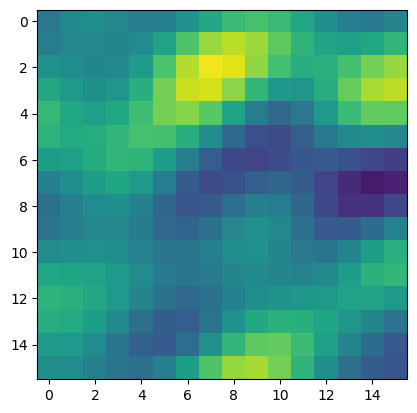

In [63]:

plt.imshow(image_data_small, vmin=-0.0001, vmax=0.0001)

## Print Self-Calibration Solution Intervals

In [44]:
imdir = "/rds/user/pmk46/hpc-work/19A-056/imaging"
selfcaldir   = os.path.join(imdir, f"{obsname}", "selfcal")
tself_file = os.path.join(selfcaldir, "tself.txt")
solint_file = os.path.join(selfcaldir, "solint.pickle")

import pickle
with open(solint_file, "rb") as file:
    solint_dict = pickle.load(file)

print(solint_dict["ST"])


41.733333333333334


## Print Flagging Statistics

In [45]:
flaggingdir = os.path.join(imdir, f"{obsname}", "flagging")
flagging_before = os.path.join(flaggingdir, "ao_flags_summary_before.npy")
flagging_after = os.path.join(flaggingdir, "rflagavg_flags_summary_after.npy")

flagstats_before = np.load(flagging_before, allow_pickle=True).item()
flagstats_after = np.load(flagging_after, allow_pickle=True).item()


In [46]:
flagstat_list = []

for spw in flagstats_before["spw"]:
    flagstat_list.append((flagstats_after["spw"][spw]["flagged"] - flagstats_before["spw"][spw]["flagged"]) / flagstats_before["spw"][spw]["total"] * 100)

print(np.mean(flagstat_list))

1.5031995025117142
